In [1]:
from IPython import display
from utils import *
import random
import numpy as np
import torch
import pickle
import timeit
import time
import argparse
import pprint
from pathlib import Path
from confs import fn, fn2, fn22, LogFn
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
import numpy.random as npr
from utilsNew import *

In [2]:
import matplotlib.pyplot as plt
import pickle

In [3]:
cudaid = 2
loglv = 2
torch.cuda.set_device(cudaid)
#------------------------------------------------------------------------------------
# fix the random seed for several packages
torch.manual_seed(0) # cpu
torch.cuda.manual_seed(0) #gpu
np.random.seed(0) #numpy
random.seed(0) #random and transforms
torch.backends.cudnn.deterministic=True # cudnn

In [4]:
cuda = torch.cuda.is_available()
if cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [6]:
def marfRun(R, CT, Cb, etaT, etab, maxIter=100, is_plot=False, is_showPro=False):
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        t0 = time.time()
        LvNow = marLossL(bThetaOld, betaOld, f, X, Y, R, is_logf=False)
        LossNow = missdepLR(LvNow, bThetaOld, betaOld, LamT, Lamb)
       
        t1 = time.time()
        # update beta
        LpbvOld = marLossLpb(bThetaOld, betaOld, conDenfs[:3], X, Y, R)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = marLossLpT(bThetaOld, betaNew, conDenfs[:3], X, Y, R)
        Losses.append(LossNow.item())
       
        t3 = time.time()
        svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        U, S, V =  svdres.U, svdres.S, svdres.V
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaErrs.append((betaNew-beta0).norm().item())
        bThetaErrs.append((bThetaNew-bTheta0).norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Beta Err")
            betaErrsArr = np.log(np.array(betaErrs))
            plt.plot(list(range(0, t+1)), betaErrsArr)
            plt.scatter(t, betaErrsArr[-1], color="red", s=20)
            plt.text(t, betaErrsArr[-1], f"Error is {np.exp(betaErrsArr[-1]):.3e}")
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Theta Err")
            bThetaErrsArr = np.log(np.array(bThetaErrs))
            plt.plot(list(range(0, t+1)), bThetaErrsArr)
            plt.scatter(t, bThetaErrsArr[-1], color="red", s=20)
            plt.text(t, bThetaErrsArr[-1], f"Error is {np.exp(bThetaErrsArr[-1]):.3e}")
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(236)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew
    res["bTheta"] = bThetaNew
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["betaErrs"] = betaErrs
    res["bThetaErrs"] = bThetaErrs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [7]:
def fRun(R, CT, Cb, etaT, etab, maxIter=100, is_plot=False, is_showPro=False):
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        t0 = time.time()
        LvNow = lossLBern(bThetaOld, betaOld, f, X, Y, R, prob=prob, fct=fct, is_logf=False)
        LossNow = missdepLR(LvNow, bThetaOld, betaOld, LamT, Lamb)
       
        t1 = time.time()
        # update beta
        LpbvOld = lossLpbBern(bThetaOld, betaOld, conDenfs[:3], X, Y, R, prob=prob, fct=fct)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = lossLpTBern(bThetaOld, betaNew, conDenfs[:3], X, Y, R, prob=prob, fct=fct)
        Losses.append(LossNow.item())
       
        t3 = time.time()
        # update Theta
        svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        U, S, V =  svdres.U, svdres.S, svdres.V
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaErrs.append((betaNew-beta0).norm().item())
        bThetaErrs.append((bThetaNew-bTheta0).norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Beta Err")
            betaErrsArr = np.log(np.array(betaErrs))
            plt.plot(list(range(0, t+1)), betaErrsArr)
            plt.scatter(t, betaErrsArr[-1], color="red", s=20)
            plt.text(t, betaErrsArr[-1], f"Error is {np.exp(betaErrsArr[-1]):.3e}")
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Theta Err")
            bThetaErrsArr = np.log(np.array(bThetaErrs))
            plt.plot(list(range(0, t+1)), bThetaErrsArr)
            plt.scatter(t, bThetaErrsArr[-1], color="red", s=20)
            plt.text(t, bThetaErrsArr[-1], f"Error is {np.exp(bThetaErrsArr[-1]):.3e}")
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(236)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew
    res["bTheta"] = bThetaNew
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["betaErrs"] = betaErrs
    res["bThetaErrs"] = bThetaErrs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [8]:
conDenfs = [fn, fn2, fn22]
f = fn
f2 = fn2

In [9]:
def genR2(Y):
    probs = torch.zeros_like(Y)
    Ystd = Y - torch.mean(Y)
    probs[Ystd>=0] = 0.00
    probs[Ystd<0] = 0.50
    uniSps = torch.rand_like(probs)
    R = uniSps <= probs
    R = R.type_as(Y).to_sparse()
    return R

In [20]:
n = m = 1600
p = 2
prob = 0.2

sigmaY = 1.0

# generate the parameters
beta0 = torch.tensor([1.0, -2.0])
bTheta0 = genbTheta(n, m, sigVs=np.array([50, 9, 8, 7, 6])*10) 
initbetapref = 1 + (torch.rand(p)-1/2)/40  #[0.875, 1.125]
initthetapref = 1 + (torch.rand(n, m)-1/2)/40
betainit = beta0 * initbetapref
bThetainit = bTheta0 * initthetapref
#betainit = torch.cat((torch.tensor([0.8, 0, 1.5, 0, -2.5, -4.3, 4.8]), torch.zeros(p-7))) * 10
#bThetainit = genbTheta(n, m, sigVs=np.array([15, 10, 7, 5, 5])/2) 

#X = genXUnif(n, m, p) 
X = genXBin(n, m, p, prob=prob) 
Y = genYnorm(X, bTheta0, beta0, sigmaY)
# around 95% missing rate
inps = {}
inps[50] = - 6.7
inps[100] = - 4.3
inps[200] = -3.40
inps[400] = -3.15
inps[800] = -3.08
inps[1600] = -3.05
R = genR2(Y)
#R = genR(Y, "linear", inp=inps[n], slop=1)
R.to_dense().mean()

tensor(0.2381)

In [21]:
print(
    torch.linalg.norm(X.to_dense().matmul(beta0), ord=2), 
    torch.linalg.norm(bTheta0, ord=2))

tensor(326.0381) tensor(500.0000)


In [22]:
tol = 1e-6
tolT = 0
tolb = 0

In [28]:
paraX=  [1e-3, 0,  1e2, 0.1] 

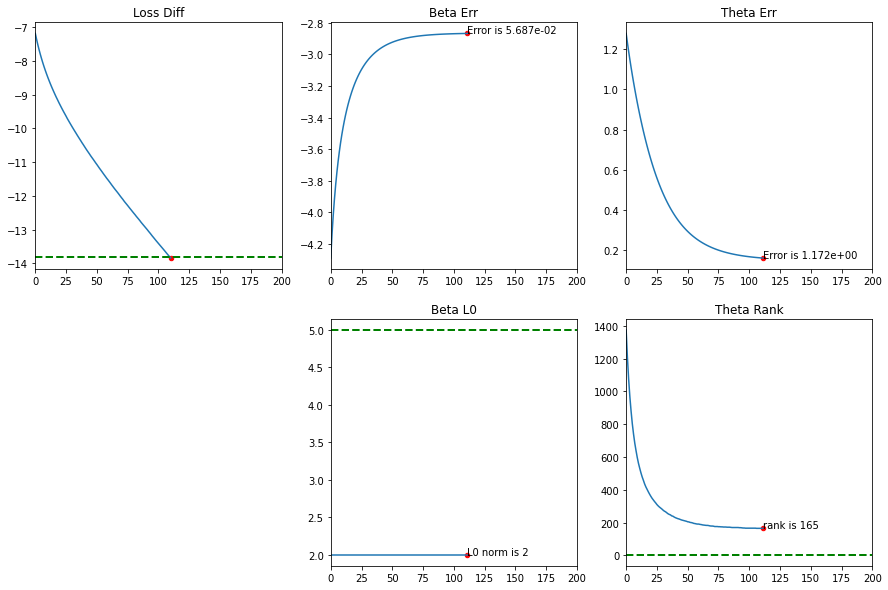

In [29]:
resMAR = marfRun(R, CT=paraX[0], Cb=paraX[1], etaT=paraX[2], etab=paraX[3], maxIter=200, is_plot=True, is_showPro=0)

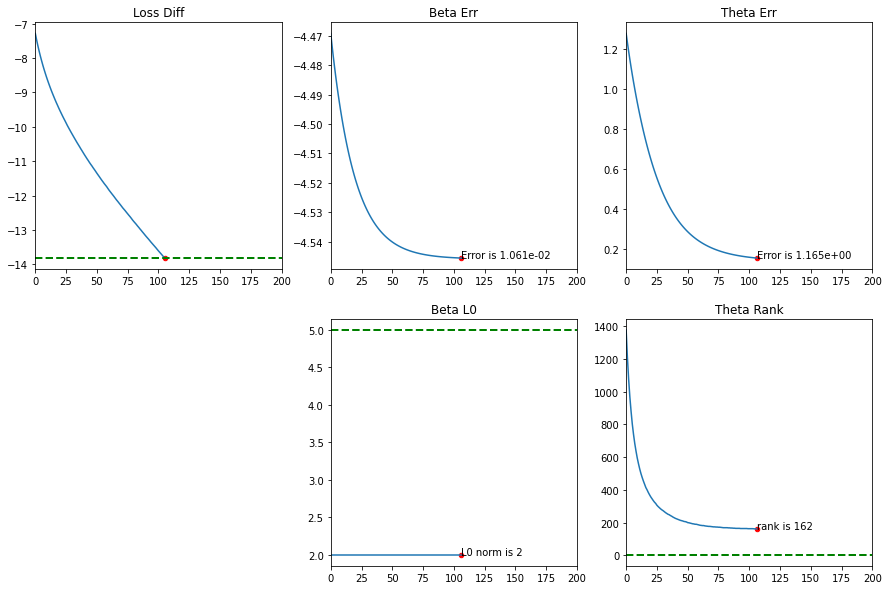

In [30]:
fct = 1
resMNAR = fRun(R, CT=paraX[0], Cb=paraX[1], etaT=paraX[2], etab=paraX[3], maxIter=200, is_plot=True, is_showPro=0)

In [ ]:
plt.plot(np.abs(np.array(resMar["bThetaErrs"][:100]) - np.array(resMnar["bThetaErrs"][:100])))

In [ ]:
plt.plot(np.abs(np.array(resMar["betaErrs"][:100]) - np.array(resMnar["betaErrs"][:100])))

In [ ]:
print(torch.norm(resMar["beta"]-beta0), torch.norm(resMnar["beta"]-beta0))
print(torch.norm(resMar["bTheta"]-bTheta0), torch.norm(resMnar["bTheta"]-bTheta0))
print(resMar["betaNorm0"], resMnar["betaNorm0"])
print(resMar["bThetaRank"], resMnar["bThetaRank"])